# Fit atmosphere parameters

- author Sylvie Dagoret-Campagne
- update August 17th 2020
- update August 18th 2020 : add scaling


BAD FIT ALL AT SAME TIME

In [409]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [410]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [411]:
DATADIR="../../data/atm"

In [412]:
atmospheric_basename_files=os.listdir(DATADIR)

In [413]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [414]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [415]:
hdu = fits.open(input_file)

In [416]:
hdr=hdu[0].header
data=hdu[0].data

In [417]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [418]:
#NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [419]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [420]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]

In [421]:
NWL=wl.shape[0]

In [422]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [423]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

### concatenate VAOD,PWV, Ozone

In [424]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [425]:
X=transm

## Splitting

In [426]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [427]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [428]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [429]:
FLAG_SCALING=True

In [430]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [431]:
scaler_X.mean_.shape

(951,)

In [432]:
scaler_X.scale_.shape

(951,)

In [433]:
scaler_Y.mean_.shape

(3,)

In [434]:
scaler_Y.scale_.shape

(3,)

In [435]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

Text(0.5, 1.0, 'Renormalised target (VAOD, O3, PWV)')

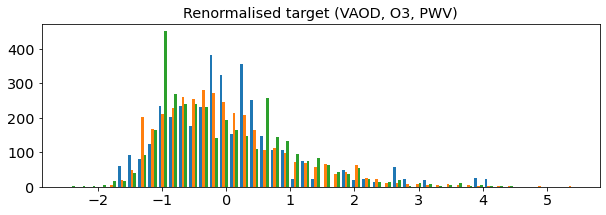

In [436]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
ax.set_title("Renormalised target (VAOD, O3, PWV)")

## Linear regression model

In [437]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [438]:
reg = linear_model.LinearRegression()

In [439]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [440]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[ 8.80566615e+07 -2.05992951e+08 -7.25957135e+06 ...  1.76891754e+00
   3.05101989e-01  3.55563083e+00]
 [ 7.04950333e+06 -1.15759130e+07 -8.43475417e+05 ...  7.42777541e-01
   6.77539238e-01  1.55611462e+00]
 [ 7.28892728e+07 -2.14613732e+08 -3.65560068e+06 ... -2.41541011e+00
  -4.09321776e+00  1.87388169e+00]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


# Linear Regression with Ridge

In [441]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [442]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[ 0.          0.          0.         ... -0.01642848 -0.01642848
  -0.00871131]
 [ 0.          0.          0.         ... -0.01111239 -0.01111239
   0.05734129]
 [ 0.          0.          0.         ...  0.29893549  0.29893549
   0.39098639]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


## Tune hyper parameter with Ridge

In [443]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.08586e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.6761e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.32359e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.03387e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.81305e-17): result may not be accurate.
  overwrite_a=True).T
/Users/dago

<Figure size 1080x1080 with 0 Axes>

In [444]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [445]:
alpha_ridge=alphas[idx_min]
alpha_ridge

1.2315506032928261e-08

5.05263106533568e-06

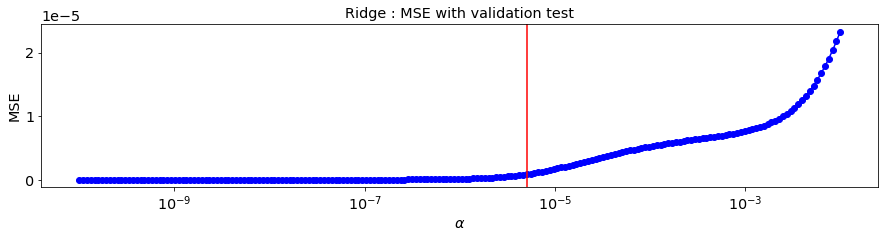

In [446]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
idx_min=np.where(all_MSE<1e-6)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
alpha_ridge

### Display results

Text(0.5, 1.0, 'Ridge : MSE with validation test')

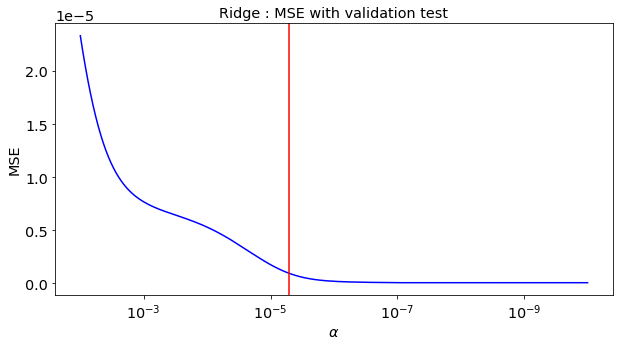

In [447]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")

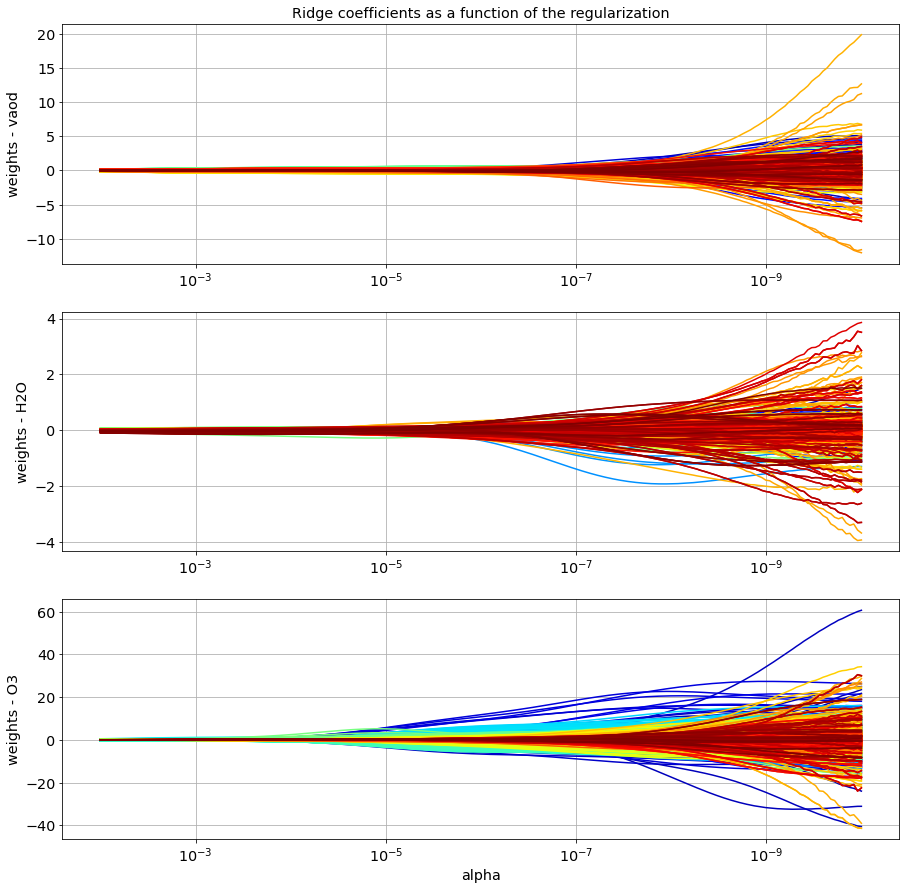

In [448]:
fig=plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax2)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [449]:
from sklearn import linear_model

In [450]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [451]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4624042818316827, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3148290525106736, tolerance: 0.21899999999999992
  positive)


Coefficients: 
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.64980617e-04
   5.11539061e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.49965309e-02
   4.01483768e-15  1.70518424e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -1.53465563e-06]]
Mean squared error: 0.00087
Coefficient of determination: 0.99918
Explained variance: 0.99918


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.264447045047458, tolerance: 0.2190000000000001
  positive)


In [452]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -2, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46910430113416873, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2045763043443936, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46910430113416934, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46922973903733417, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.205321081363274, tolerance: 0.219
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46941546917108906, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2233148743282145, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7830184764724596, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.455661695360695, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3568492026018002, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46356819961022566, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6949303674742779, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

<Figure size 1080x1080 with 0 Axes>

0.0005455594781168515

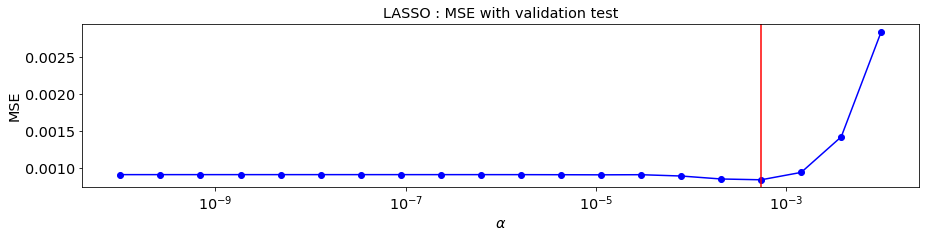

In [453]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
alpha_lasso

Text(0.5, 1.0, 'LASSO : MSE with validation test')

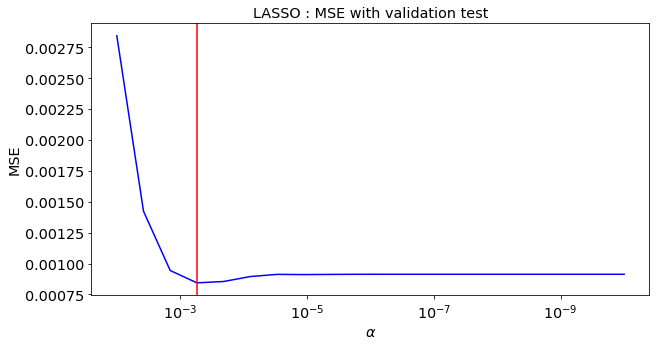

In [454]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")

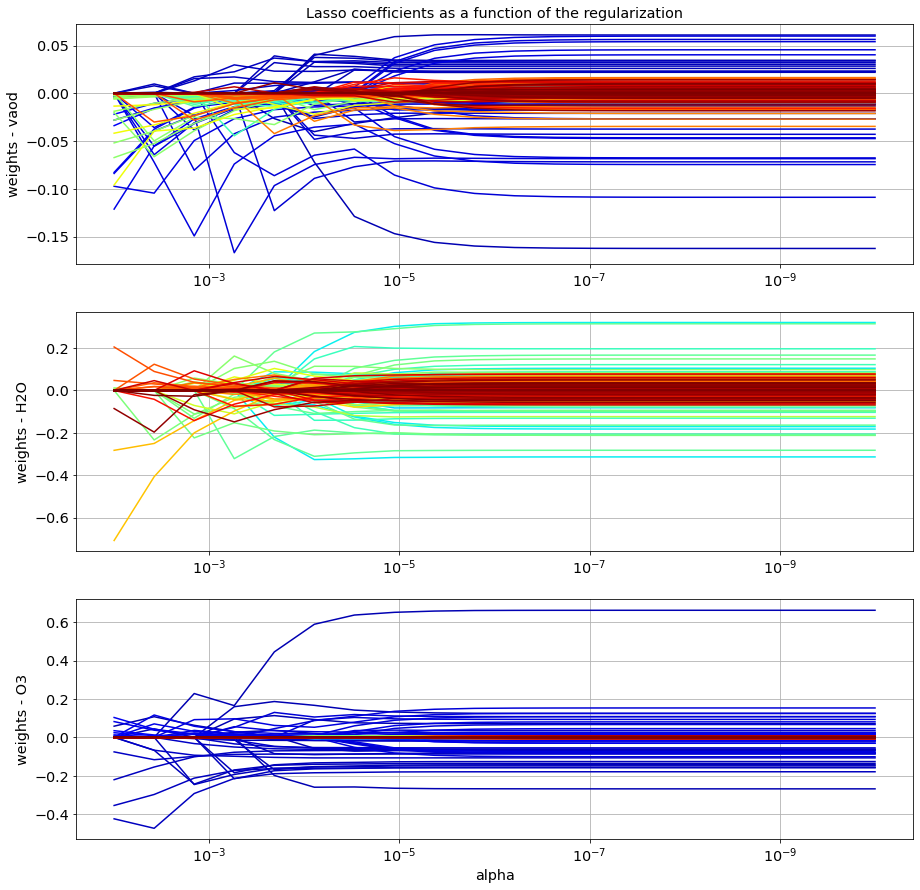

In [455]:
fig=plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [456]:
nb_tot_test=len(Y_test)

In [457]:
nsamples=np.arange(10,nb_tot_test,10)

### Learning curves for Ridge

In [458]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [459]:
nsamples

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720])

In [460]:
count=0
for n in nsamples:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

Text(0.5, 1.0, 'RIDGE : MSE with test vs N')

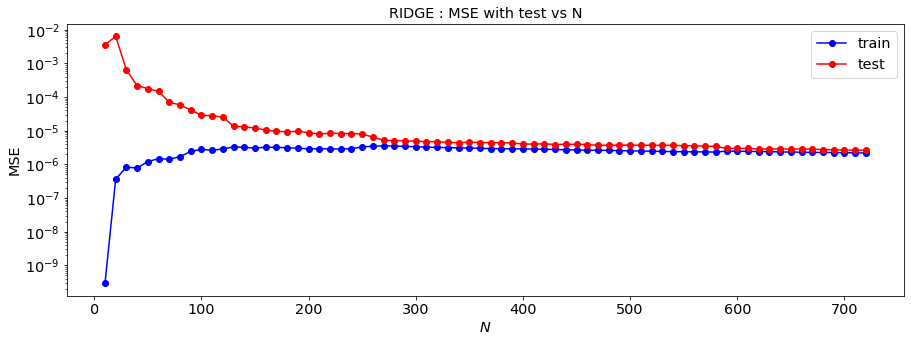

In [461]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")

### Learning curves for Lasso

In [462]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [463]:
count=0
for n in nsamples:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013754416473939885, tolerance: 0.0003225237752955068
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004392234845977483, tolerance: 0.0007725971819792289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018061488847546771, tolerance: 0.0013816174307627607
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge.

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044494869485043984, tolerance: 0.008920985905889823
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08264118989577626, tolerance: 0.013839464739077677
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011193691128567863, tolerance: 0.00913938823387343
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13737670339546726, tolerance: 0.021333681396454564
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019765283213566298, tolerance: 0.01663285626655666
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12477955319953109, tolerance: 0.02326050280238628
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You migh

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20086927134460195, tolerance: 0.03745135052275409
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2143300820177867, tolerance: 0.032788792530929034
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028548965086765105, tolerance: 0.02765265823051717
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25645667369532477, tolerance: 0.04851746351435983
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27361917850100215, tolerance: 0.042006746706543065
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0404361332288351, tolerance: 0.036445291370037144
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3097078134909209, tolerance: 0.0588709969742803
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3299956956273048, tolerance: 0.05034890467652633
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05457895931623191, tolerance: 0.0463955480104635
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4260259543885103, tolerance: 0.06496034609865653
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06906667489879686, tolerance: 0.05874371619948677
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3581832630532857, tolerance: 0.06756262699455105
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wa

Text(0.5, 1.0, 'LASSO : MSE with test vs N')

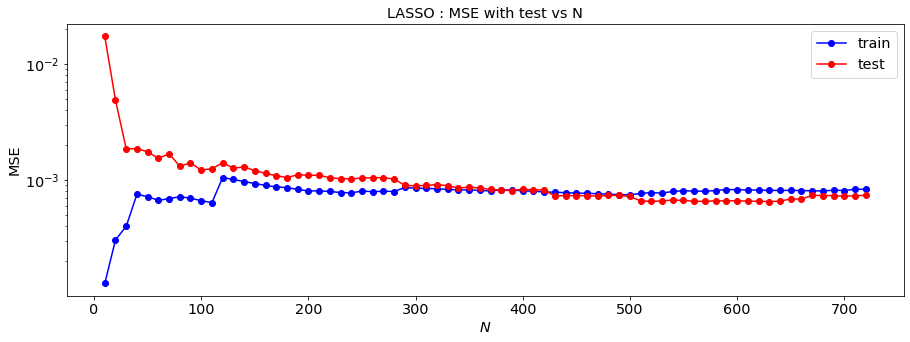

In [464]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")

# Final

## Ridge

In [465]:
ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [466]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


Text(0.5, 1, 'Linear Regression + Ridge reg, (no cloud)')

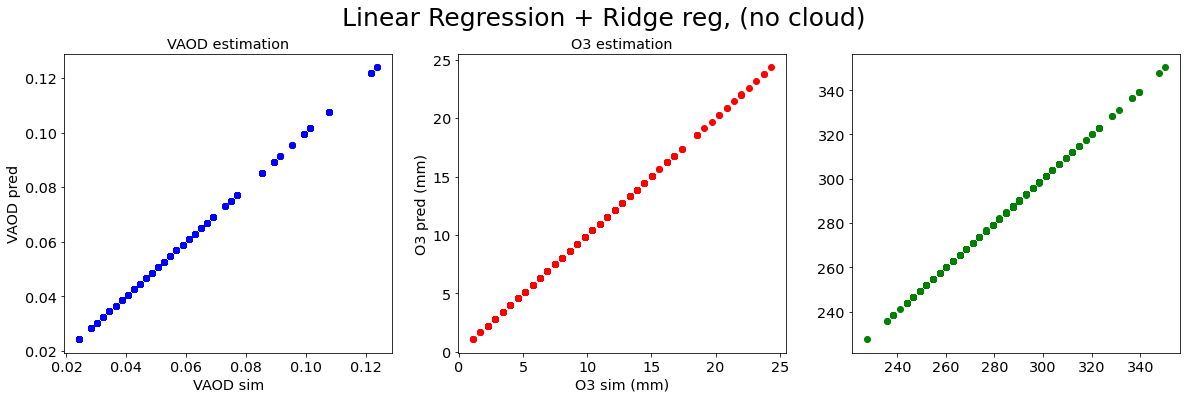

In [467]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")
ax.set_xlabel("O3 sim (mm)")
ax.set_ylabel("O3 pred (mm)")
ax.set_title("O3 estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')

plt.suptitle("Linear Regression + Ridge reg, (no cloud)",Y=1,fontsize=25)

Text(0.5, 1, 'Linear Regression + Ridge reg, (no cloud)')

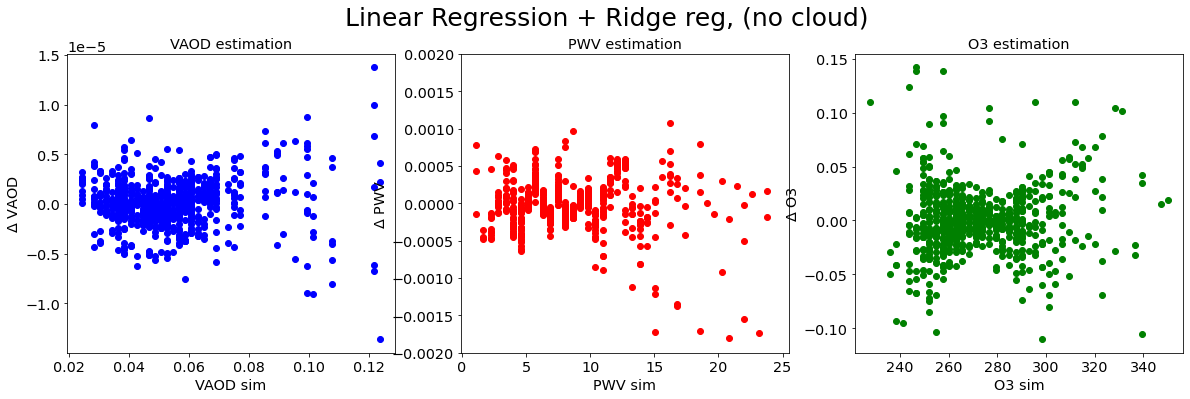

In [468]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.suptitle("Linear Regression + Ridge reg, (no cloud)",Y=1,fontsize=25)

Text(0.5, 1, 'Linear Regression + Ridge reg, (no cloud)')

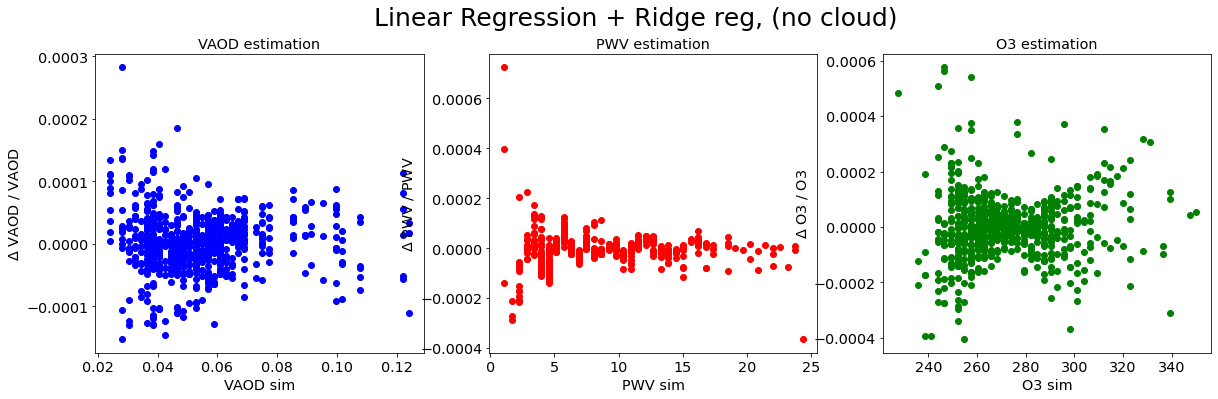

In [469]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.suptitle("Linear Regression + Ridge reg, (no cloud)",Y=1,fontsize=25)

## Lasso

In [470]:
lasso = linear_model.Lasso(alpha=alpha_lasso, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25397310961462627, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.161864116030131, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4965569012417177, tolerance: 0.2190000000000001
  positive)


In [471]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00082
Coefficient of determination: 0.99922
Explained variance: 0.99922


Text(0.5, 1, 'Linear Regression + Lasso reg, (no cloud)')

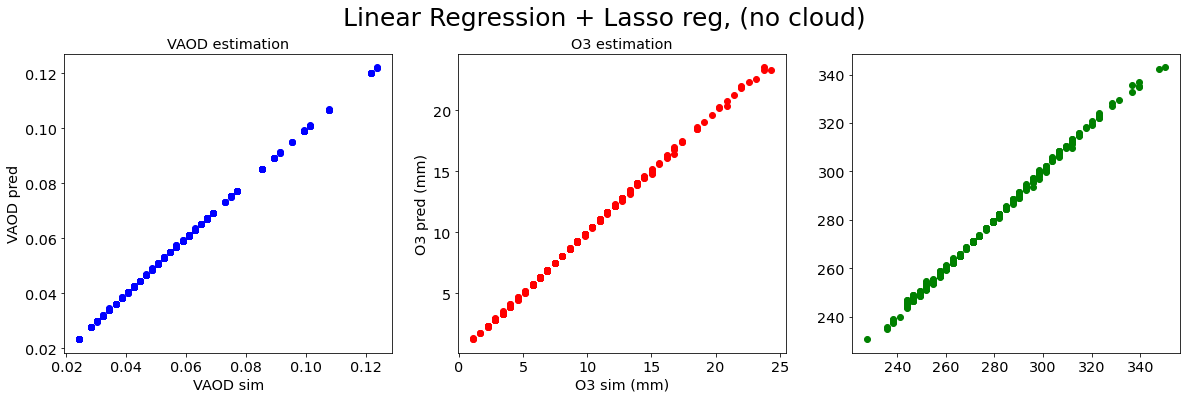

In [472]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")
ax.set_xlabel("O3 sim (mm)")
ax.set_ylabel("O3 pred (mm)")
ax.set_title("O3 estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')

plt.suptitle("Linear Regression + Lasso reg, (no cloud)",Y=1,fontsize=25)

Text(0.5, 1, 'Linear Regression + Lasso reg, (no cloud)')

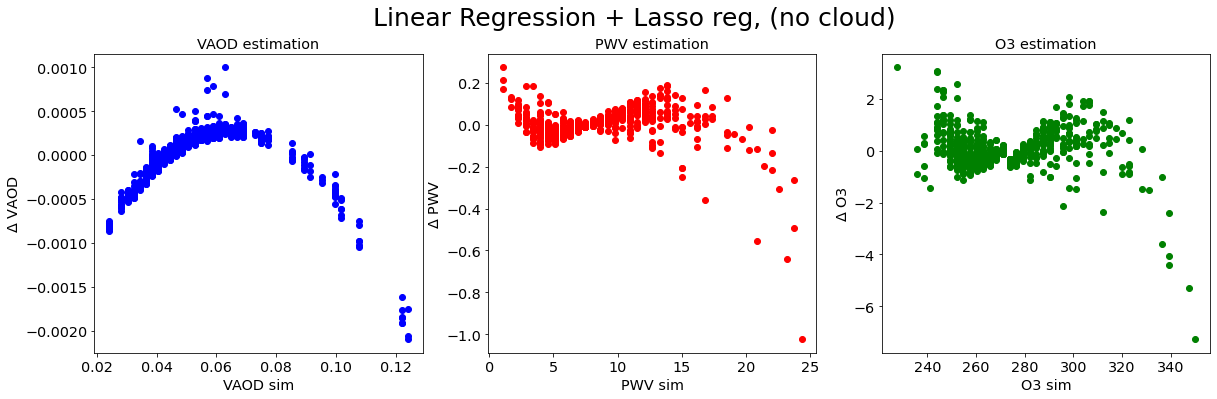

In [473]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.suptitle("Linear Regression + Lasso reg, (no cloud)",Y=1,fontsize=25)

Text(0.5, 1, 'Linear Regression + Lasso reg, (no cloud)')

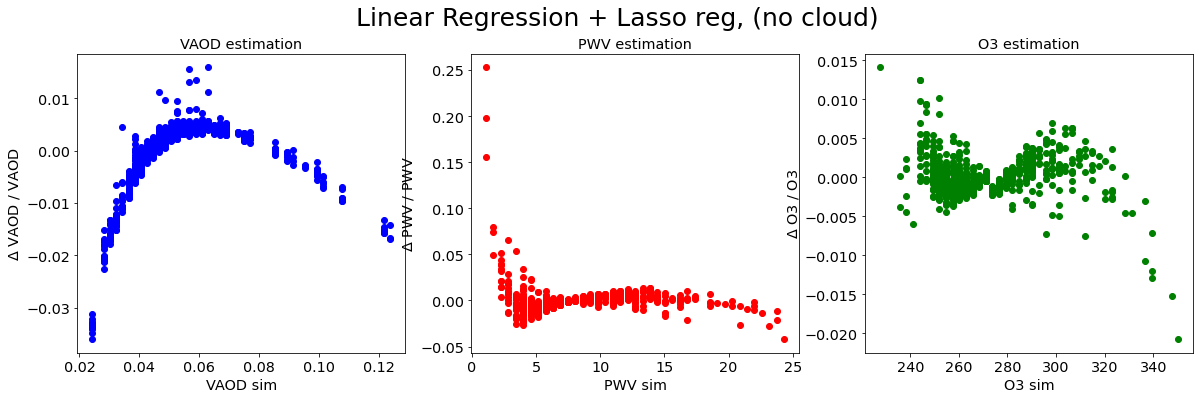

In [474]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.suptitle("Linear Regression + Lasso reg, (no cloud)",Y=1,fontsize=25)